In [31]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import ase.io as io

from abtem.parametrizations import LobatoParametrization

from ase.io import read
from ase.visualize import view
from ase.io import write

pd.set_option("display.float_format", "{:.3f}".format)
pd.set_option('display.max_columns', 15)

abtem.config.set({"local_diagnostics.progress_bar": False});

In [32]:
atoms = io.read(r'C:\Users\Joshu\OneDrive\Desktop\For python\Models\Al.cfg')

view(atoms)

<Popen: returncode: None args: ['C:\\Users\\Joshu\\anaconda3\\envs\\myenv\\p...>

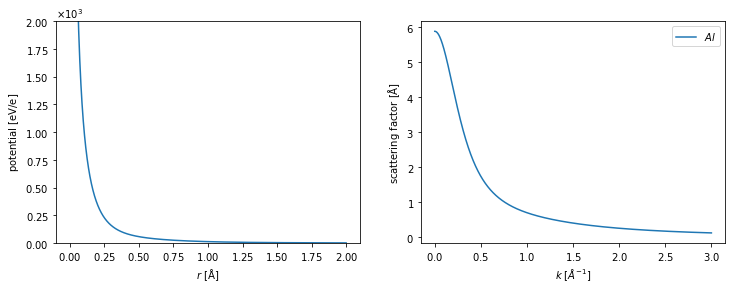

In [33]:
symbols = ["Al"]
parametrization = LobatoParametrization()

potentials = parametrization.line_profiles(symbols, cutoff=2, name="potential")
scattering_factor = parametrization.line_profiles(
    symbols, cutoff=3, name="scattering_factor"
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
visualization = potentials.show(ax=ax1)
visualization.set_ylim([0, 2e3])

scattering_factor.show(legend=True, ax=ax2);

In [34]:
atoms = read(r'C:\Users\Joshu\OneDrive\Desktop\For python\Models\Al.cfg')
repeated_atoms = atoms * (2, 2, 6)

potential = abtem.Potential(
    repeated_atoms,
    sampling=0.05,
    parametrization="lobato",
    slice_thickness=1,
    projection="finite",
)

In [35]:
probe = abtem.Probe(
    sampling=0.05,
    extent=20,
    energy=200e3,
    semiangle_cutoff=20,
    C10=0,
    Cs=-50e-6 * 1e10,
)

In [36]:
potential = abtem.Potential(atoms, slice_thickness=4.08 / 2, sampling=0.04)

plane_wave = abtem.PlaneWave(energy=200e3)

In [37]:
exit_waves_line = probe.multislice(potential=potential, scan=line_scan)

In [38]:
bright = abtem.AnnularDetector(inner=0, outer=30)
maadf = abtem.AnnularDetector(inner=50, outer=120)
haadf = abtem.AnnularDetector(inner=90, outer=200)

print(
    f"Maximum simulated scattering angle = {min(exit_waves_line.cutoff_angles):.1f} mrad"
)

Maximum simulated scattering angle = 200.6 mrad


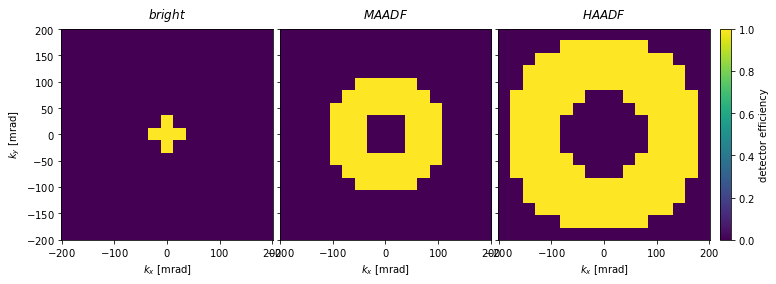

In [39]:
bright_region = bright.get_detector_region(exit_waves_line)
maadf_region = maadf.get_detector_region(exit_waves_line)
haadf_region = haadf.get_detector_region(exit_waves_line)

stacked_regions = abtem.stack(
    (bright_region, maadf_region, haadf_region), ("bright", "MAADF", "HAADF")
)

visualization = stacked_regions.show(
    explode=True, cbar=True, common_color_scale=True, units="mrad", figsize=(12, 4)
)

In [40]:
haadf.detect(exit_waves_line)

In [41]:
all_detectors = [bright, maadf, haadf]

measurements = probe.scan(potential, detectors=all_detectors, scan=line_scan).compute();

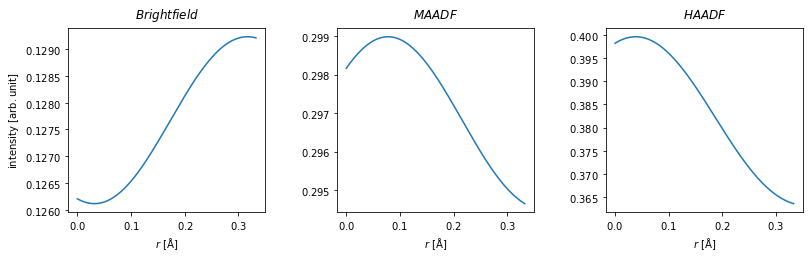

In [42]:
measurements = abtem.stack(measurements, ("Bright field", "MAADF", "HAADF"))

visualization = measurements.show(explode=True, common_scale=False, figsize=(12, 3))

visualization.set_axes_padding([1.0, 0])

In [43]:
sampling = probe.aperture.nyquist_sampling
print(f"Nyquist sampling = {sampling:.3f} Å/pixel")

Nyquist sampling = 0.313 Å/pixel


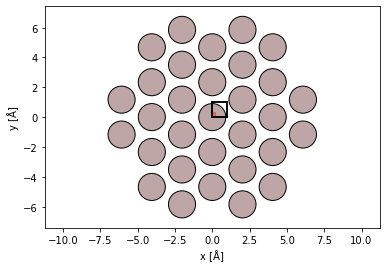

In [44]:
grid_scan = abtem.GridScan(
    start=[0, 0],
    end=[1 / 5, 1 / 3],
    sampling=sampling,
    fractional=True,
    potential=potential,
)

fig, ax = abtem.show_atoms(atoms)
grid_scan.add_to_plot(ax)

In [45]:
measurements = probe.scan(potential, scan=grid_scan, detectors=all_detectors)

In [46]:
measurements = abtem.stack(measurements, ("BF", "MAADF", "HAADF"))

In [47]:
measurements.to_zarr("mos2_stem_measurements.zarr");

In [48]:
imported_measurements = abtem.from_zarr("mos2_stem_measurements.zarr").compute()

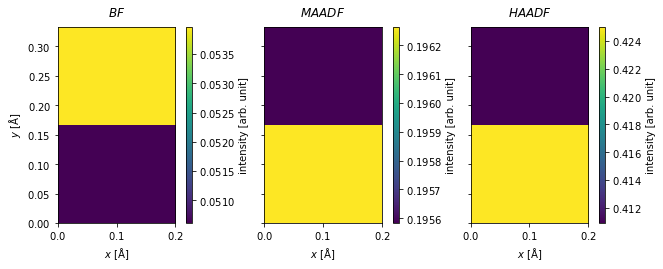

In [49]:
imported_measurements.show(explode=True, cbar=True, figsize=(10, 5));

In [50]:
interpolated_measurement = imported_measurements.interpolate(sampling=0.1)

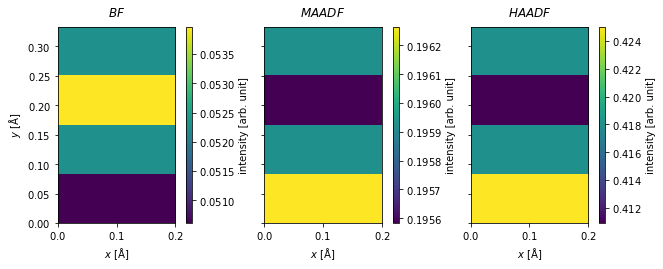

In [51]:
interpolated_measurement.show(explode=True, cbar=True, figsize=(10, 5));

In [52]:
pixelated_detector = abtem.PixelatedDetector(max_angle=200)

pixelated_measurements = probe.scan(
    potential,
    scan=grid_scan,
    detectors=pixelated_detector,
)
pixelated_measurements.compute()

In [53]:
cropped_diffraction_pattern = pixelated_measurements[1, 1].crop(max_angle=80)

abtem.stack(
    [
        cropped_diffraction_pattern,
        cropped_diffraction_pattern.block_direct(),
    ],
    ("base", "block direct"),
).show(explode=True, cbar=True, figsize=(12, 4));

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
stacked = abtem.stack(
    [
        pixelated_measurements.integrate_radial(0, 30),
        pixelated_measurements.integrate_radial(50, 120),
        pixelated_measurements.integrate_radial(90, 200),
    ],
    ("BF", "MAADF", "HAADF"),
)

stacked.show(explode=True, cbar=True, figsize=(10, 5));

In [ ]:
center_of_mass = pixelated_measurements.center_of_mass(units="1/Å")

interpolated_center_of_mass = center_of_mass.interpolate(0.05).tile((3, 2))

interpolated_center_of_mass.show(cbar=True);

In [ ]:
integrated_gradient = center_of_mass.integrate_gradient()

interpolated_integrated_gradient = integrated_gradient.interpolate(0.05).tile((3, 2))

interpolated_integrated_gradient.show(cbar=True);